## Automated anisotropic resistivity inversion for efficient formation evaluation and uncertainty quantification

### Misael M. Morales, Oriyomi Raheem, Ali Eghbali, Michael Pyrcz, Carlos Torres-Verdin
***

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.animation import FuncAnimation

import lasio
import pywt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy import linalg, optimize
from scipy.io import loadmat
from numdifftools import Jacobian, Hessian
from sklearn.linear_model import LinearRegression

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

my_box = dict(facecolor='lightgrey', edgecolor='k', alpha=0.5)

In [2]:
def plot_curve(ax, df, curve, lb=None, ub=None, color='k', pad=0, s=2, mult=1,
            units:str=None, mask=None, offset:int=0, title:str=None, label:str=None,
            semilog:bool=False, bar:bool=False, fill:bool=None, rightfill:bool=False,
            marker=None, edgecolor=None, ls=None, alpha=None):
        if mask is None:
            x, y = -offset+mult*df[curve], df.index
        else:
            x, y = -offset+mult*df[curve][mask], df.index[mask]
        lb = x[~np.isnan(x)].min() if lb is None else lb
        ub = x[~np.isnan(x)].max() if ub is None else ub
        if semilog:
            ax.semilogx(x, y, c=color, label=curve, alpha=alpha,
                        marker=marker, markersize=s, markeredgecolor=edgecolor, linestyle=ls, linewidth=s)
        else:
            if bar:
                ax.barh(y, x, color=color, label=curve, alpha=alpha)
            else:
                ax.plot(x, y, c=color, label=curve, alpha=alpha,
                        marker=marker, markersize=s, markeredgecolor=edgecolor, linewidth=s, linestyle=ls)
        if fill:
            if rightfill:
                ax.fill_betweenx(y, x, ub, alpha=alpha, color=color)
            else:
                ax.fill_betweenx(y, lb, x, alpha=alpha, color=color)
        if units is None:
            if hasattr(df, 'curvesdict'):
                units = df.curvesdict[curve].unit
            else:
                units = ''
        ax.set_xlim(lb, ub)
        ax.grid(True, which='both')
        ax.set_title(title, weight='bold') if title != None else None
        xlab = label if label is not None else curve
        if offset != 0:
            ax.set_xlabel('{} [{}] with {} offset'.format(xlab, units, offset), color=color, weight='bold')
        else:
            ax.set_xlabel('{} [{}]'.format(xlab, units), color=color, weight='bold')
        ax.xaxis.set_label_position('top'); ax.xaxis.set_ticks_position('top')
        ax.xaxis.set_tick_params(color=color, width=s)
        ax.spines['top'].set_position(('axes', 1+pad/100))
        ax.spines['top'].set_edgecolor(color); ax.spines['top'].set_linewidth(2)
        if ls is not None:
            ax.spines['top'].set_linestyle(ls)
        return None

In [3]:
def error_metrics(df):
    mse_rv = mean_squared_error(df['Rv'], df['Rv_sim'])
    mse_rh = mean_squared_error(df['Rh'], df['Rh_sim'])

    r2_rv = r2_score(df['Rv'], df['Rv_sim'])*100
    r2_rh = r2_score(df['Rh'], df['Rh_sim'])*100

    sterr_rv = np.mean(np.abs(df['Rv']-df['Rv_sim'])) / np.std(np.abs(df['Rv']-df['Rv_sim']))
    sterr_rh = np.mean(np.abs(df['Rh']-df['Rh_sim'])) / np.std(np.abs(df['Rh']-df['Rh_sim']))

    percerr_rv = np.mean(np.abs((df['Rv']-df['Rv_sim'])/df['Rv'])) * 100
    percerr_rh = np.mean(np.abs((df['Rh']-df['Rh_sim'])/df['Rh'])) * 100

    print('Mean Squared Error - Rv: {:.4f}  | Rh: {:.4f}'.format(mse_rv, mse_rh))
    print('R2 Score           - Rv: {:.3f}  | Rh: {:.3f}'.format(r2_rv, r2_rh))
    print('Standard Error     - Rv: {:.4f}  | Rh: {:.4f}'.format(sterr_rv, sterr_rh))
    print('Percentage Error   - Rv: {:.4f}% | Rh: {:.4f}%'.format(percerr_rv, percerr_rh))

In [4]:
'''
Check if Torch is successfully built with GPU support
'''
torch_version, cuda_avail = torch.__version__, torch.cuda.is_available()
count, name = torch.cuda.device_count(), torch.cuda.get_device_name()
print('\n'+'-'*60)
print('----------------------- VERSION INFO -----------------------')
print('Torch version: {} | Torch Built with CUDA? {}'.format(torch_version, cuda_avail))
print('# Device(s) available: {}, Name(s): {}'.format(count, name))
print('-'*60+'\n')


------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.2.2+cu121 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3080
------------------------------------------------------------



In [33]:
column_names = ['AT10', 'AT30', 'AT60', 'AT90', 'GR', 'Rv', 'Rh']
index_name   = 'DEPTH'

# well 1
well1 = lasio.read('well1.las').df()
case1 = well1[['AT10','AT30','AT60','AT90','GR','RV72H_1D_FLT','RH72H_1D_FLT']].dropna() #['RV72H_1D','RH72H_1D']
case1.columns = column_names
case1.index.name = index_name

# well 2
well2 = lasio.read('well2.LAS').df()
case2 = well2[['AT10','AT30','AT60','AT90','HCGR','RV72_1DF','RH72_1DF']].dropna()
case2.columns = column_names
case2.index.name = index_name

# synthetic 1
synthetic_raw = lasio.read('synthetic_cases/Case1.las').df()
synthetic_raw = synthetic_raw.join(lasio.read('synthetic_cases/Case1_RvRh.las').df())
synthetic_names = ['GR','DPHI','NPHI','PEF','AT10', 'AT30', 'AT60', 'AT90', 'Rh', 'Rv']
synthetic = synthetic_raw[['ECGR','DPHI','NPHI','PEF','RF10', 'RF30', 'RF60', 'RF90', 
                           'RESISTIVITY FORMATION (UNINVADED)', 'RESISTIVITY (PERPENDICULAR) FORMATION (UNINVADED)']]
synthetic.columns = synthetic_names
synthetic = synthetic.loc[5479.9:5680.1]

# synthetic 2
synthetic2_raw = lasio.read('synthetic_cases/Case2.las').df()
synthetic2_names = ['GR','RHOZ','NPOR','PEFZ','Rv','Rh']
synthetic2 = synthetic2_raw[['GR','RHOZ','NPOR','PEFZ','RD_V','RD_H']].dropna()
synthetic2.columns = synthetic2_names
synthetic2 = synthetic2.loc[:5195]

In [6]:
def plot_inversion_solution(data, sol, ali, figsize=(16.5,10)):
    fig, axs = plt.subplots(1,5, figsize=figsize, sharey=True, width_ratios=[0.6,0.6,0.6,1,1])
    ax1, ax2, ax3, ax4, ax5 = axs
    colors = ['darkviolet','royalblue','firebrick']
    ax1.plot(data['GR'], data.index, c='g', label='GR')
    ax1.grid(True, which='both')
    ax1.set(xlim=(20,120), title='GR')
    ax1.hlines(10188.75, 0, data['GR'].max(), color='k', lw=5)
    ax2.plot(data['Rv'], data.index, c='k', label='Rv')
    ax2.plot(ali['Rv_sim'], ali['df'].iloc[1:2156,0], c='b', ls='--', label='Ali_sim')
    ax2.plot(sol['Rv_sim'], sol.index, c='r', ls='--', label='Simulated')
    ax2.set(xscale='log', title='Rv')
    ax2.grid(True, which='both')
    ax2.legend(loc='upper left', facecolor='lightgrey', edgecolor='k')
    ax2.hlines(10188.75, 0, sol['Rss_pred'].max(), color='k', lw=5)
    ax3.plot(data['Rh'], data.index, c='k', label='Rh')
    ax3.plot(ali['Rh_sim'], ali['df'].iloc[1:2156,0], c='b', ls='--', label='Ali_sim')
    ax3.plot(sol['Rh_sim'], sol.index, c='r', ls='--', label='Simulated')
    ax3.set(xscale='log', title='Rh')
    ax3.grid(True, which='both')
    ax3.legend(loc='upper left', facecolor='lightgrey', edgecolor='k')
    ax3.hlines(10188.75, 0, sol['Rss_pred'].max(), color='k', lw=5)
    ax4.plot(ali['Csh'], ali['df'].iloc[1:2156,0], label='Ali_1', c='b')
    ax4.plot(ali['df'].iloc[:,14], ali['df'].iloc[:,0], label='Ali_2')
    ax4.plot(sol['Csh_pred'], sol.index, label='Mine', ls='--', c='r')
    ax4.set(title='Csh', xlim=(0,1))
    ax4.legend(loc='upper left', facecolor='lightgrey', edgecolor='k')
    ax4.grid(True, which='both')
    ax4.hlines(10188.75, 0, 1, color='k', lw=5)
    ax5.plot(ali['Rss'], ali['df'].iloc[1:2156,0], label='Ali_1', c='b')
    ax5.plot(ali['df'].iloc[:,15], ali['df'].iloc[:,0], label='Ali_2')
    ax5.plot(sol['Rss_pred'], sol.index, label='Mine', ls='--', c='r')
    ax5.set(xscale='log', title='Rss'); 
    ax5.legend(loc='upper left', facecolor='lightgrey', edgecolor='k')
    ax5.grid(True, which='both')
    ax5.hlines(10188.75, 0, sol['Rss_pred'].max(), color='k', lw=5)
    ax1.invert_yaxis()
    plt.tight_layout()
    plt.show()

In [7]:
def plot_inversion_comparison(sol, ali, figsize=(15,10)):
    fig, axs = plt.subplots(1, 6, figsize=figsize, sharey=True)
    ax1, ax2, ax3, ax4, ax5, ax6 = axs
    ax1.plot(sol['Rv'], sol.index, c='k', lw=2.75, label='Rv_true')
    ax1.plot(sol['Rv_sim'], sol.index, c='r', ls='--', label='Rv_sim')
    ax1.set(title='Rv_sim'); ax1.grid(True, which='both'); ax1.set_xscale('log')
    ax1.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')
    ax2.plot(sol['Rh'], sol.index, c='k', lw=2.75, label='Rh_true')
    ax2.plot(sol['Rh_sim'], sol.index, c='r', ls='--', label='Rh_sim')
    ax2.set(title='Rh_sim'); ax2.grid(True, which='both'); ax2.set_xscale('log')
    ax2.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')
    ax3.plot(sol['Rv'], sol.index, c='k', lw=2.75, label='Rv_true')
    ax3.plot(ali['Rv_sim'], ali['df'].iloc[:2155,0], c='b', ls='--', label='ALI_Rv_sim')
    ax3.set(title='Rv_sim'); ax3.grid(True, which='both'); ax3.set_xscale('log')
    ax3.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')
    ax4.plot(sol['Rh'], sol.index, c='k', lw=2.75, label='Rh_true')
    ax4.plot(ali['Rh_sim'], ali['df'].iloc[:2155,0], c='b', ls='--', label='ALI_Rh_sim')
    ax4.set(title='Rh_sim'); ax4.grid(True, which='both'); ax4.set_xscale('log')
    ax4.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')
    ax5.plot(sol['Rv'], sol.index, c='k', lw=2.75, label='Rv_true')
    ax5.plot(ali['Rv_sim'], ali['df'].iloc[:2155,0], c='b', ls='--', label='ALI_Rv_sim')
    ax5.plot(sol['Rv_sim'], sol.index, c='r', ls='--', label='Rv_sim')
    ax5.set(title='Rv_sim'); ax5.grid(True, which='both'); ax5.set_xscale('log')
    ax5.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')
    ax6.plot(sol['Rh'], sol.index, c='k', lw=2.75, label='Rh_true')
    ax6.plot(ali['Rh_sim'], ali['df'].iloc[:2155,0], c='b', ls='--', label='ALI_Rh_sim')
    ax6.plot(sol['Rh_sim'], sol.index, c='r', ls='--', label='Rh_sim')
    ax6.set(title='Rh_sim'); ax6.grid(True, which='both'); ax6.set_xscale('log')
    ax6.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')
    for ax in axs:
        ax.hlines(10188.75, 0, sol['Rss_pred'].max(), color='k', lw=3.5)
    ax1.invert_yaxis()
    plt.tight_layout()
    plt.show()


In [8]:
def plot_inversion_fullsuite(data, sol, ali_sol, figsize=(17.5,10)):
    df = lasio.read('well1.las').df()
    fig, axs = plt.subplots(1, 10, figsize=figsize, sharey=True)
    ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = axs
    ax01, ax02 = ax0.twiny(), ax0.twiny()
    plot_curve(ax0, df, 'CALI', 12, 24, 'dodgerblue', units='in', fill=True, semilog=True, pad=0)
    plot_curve(ax01, df, 'GR', 10, 150, 'g', units='API', pad=8)
    plot_curve(ax02, sol, 'Csh_pred', 0, 1, 'r', units='v/v', s=1, pad=16)
    ax11, ax12 = ax1.twiny(), ax1.twiny()
    plot_curve(ax1, data, 'Csh_lin', 0, 1, 'k', units='v/v', pad=0)
    plot_curve(ax11, data, 'Csh_q', 0, 1, 'gray', units='v/v', pad=8)
    plot_curve(ax12, sol, 'Csh_pred', 0, 1, 'r', units='v/v', pad=16)
    ax21, ax22 = ax2.twiny(), ax2.twiny()
    plot_curve(ax2, df, 'TNPH', 1, 0, 'b', units='PU', pad=0)
    plot_curve(ax21, df, 'RHOZ', 1.65, 2.65, 'maroon', units='g/cc', pad=8)
    plot_curve(ax22, df, 'PE', -5, 5, 'm', units='b/e', pad=16)
    ax31, ax32 = ax3.twiny(), ax3.twiny()
    plot_curve(ax3, df, 'AT10', 0.2, 100, 'darkred', semilog=True, units='$\Omega\cdot m$', pad=0)
    plot_curve(ax31, df, 'AT90', 0.2, 100, 'darkblue', semilog=True, units='$\Omega\cdot m$', pad=8)
    plot_curve(ax32, sol, 'Rss_pred', 0.2, 100, 'r', semilog=True, units='$\Omega\cdot m$', pad=16)
    ax41 = ax4.twiny()
    plot_curve(ax4, ali_sol, 'Csh_ALI', 0, 1, 'b', units='v/v', pad=0)
    plot_curve(ax41, sol, 'Csh_pred', 0, 1, 'r', ls='--', units='v/v', pad=8)
    ax51 = ax5.twiny()
    plot_curve(ax5, ali_sol, 'Rss_ALI', 0.2, 100, 'b', semilog=True, units='$\Omega\cdot m$', pad=0)
    plot_curve(ax51, sol, 'Rss_pred', 0.2, 100, 'r', ls='--', semilog=True, units='$\Omega\cdot m$', pad=8)
    ax61, ax62 = ax6.twiny(), ax6.twiny()
    plot_curve(ax6, df, 'RV72H_1D_FLT', 0.2, 100, 'k', s=4, semilog=True, units='$\Omega\cdot m$', pad=0)
    plot_curve(ax61, ali_sol, 'Rv_sim_ALI', 0.2, 100, 'b', semilog=True, units='$\Omega\cdot m$', pad=8)
    plot_curve(ax62, sol, 'Rv_sim', 0.2, 100, 'r', ls='--', semilog=True, units='$\Omega\cdot m$', pad=16)
    ax71, ax72 = ax7.twiny(), ax7.twiny()
    plot_curve(ax7, df, 'RH72H_1D_FLT', 0.2, 100, 'k', s=4, semilog=True, units='$\Omega\cdot m$', pad=0)
    plot_curve(ax71, ali_sol, 'Rh_sim_ALI', 0.2, 100, 'b', semilog=True, units='$\Omega\cdot m$', pad=8)
    plot_curve(ax72, sol, 'Rh_sim', 0.2, 100, 'r', ls='--', semilog=True, units='$\Omega\cdot m$', pad=16)
    ax81, ax82, ax83 = ax8.twiny(), ax8.twiny(), ax8.twiny()
    plot_curve(ax8, data, 'Rv', 0.2, 100, 'k', s=4, semilog=True, units='$\Omega\cdot m$', pad=0)
    plot_curve(ax81, sol, 'Rv_sim', 0.2, 100, 'darkred', ls='--', semilog=True, units='$\Omega\cdot m$', pad=8)
    plot_curve(ax82, data, 'Rh', 0.2, 100, 'k', s=4, semilog=True, units='$\Omega\cdot m$', pad=16)
    plot_curve(ax83, sol, 'Rh_sim', 0.2, 100, 'darkblue', ls='--', semilog=True, units='$\Omega\cdot m$', pad=24)
    ax91, ax92 = ax9.twiny(), ax9.twiny()
    plot_curve(ax9, sol, 'fun', 1e-6, 1e0, 'k', s=1, semilog=True, units='/', pad=0)
    plot_curve(ax91, sol, 'jac_norm', 0, 2.5, 'darkmagenta', s=1, units='/', pad=8, alpha=0.5)
    plot_curve(ax92, sol, 'nfev', 10, 150, 'darkgreen', s=1, units='/', pad=16, alpha=0.5)
    ax1.set_ylim(10190, 9650)
    plt.tight_layout()
    plt.show()

In [9]:
def plot_short_results(data, sol, figsize=(6,8), cfactor=5):
    fig, axs = plt.subplots(1, 3, figsize=figsize, sharey=True)
    ax1, ax2, ax3 = axs
    c = cfactor*(data['CALI'] - data['CALI'].mean()) / data['CALI'].std()
    ax1.plot(data['GR'], data.index, c='g', label='GR')
    ax1.plot(c, data.index, c='dodgerblue', label='CALI')
    ax2.plot(data['Rv'], data.index, c='k', label='Rv')
    ax2.plot(sol['Rv_sim'], sol.index, c='r', ls='--', label='Rv_sim')
    ax2.plot(data['Rh'], data.index, c='k', label='Rh')
    ax2.plot(sol['Rh_sim'], sol.index, c='b', ls='--', label='Rh_sim')
    ax2.set_xscale('log')
    ax3.plot(sol['Csh_pred'], sol.index, c='k', label='Csh_pred')
    for ax in axs:
        ax.grid(True, which='both')
        ax.legend(loc='upper right', facecolor='lightgrey', edgecolor='k')
    ax1.invert_yaxis()
    plt.tight_layout()
    plt.show()

In [10]:
def plot_crossplot(sol, figsize=(10,4), cmap='jet', alpha=0.66, vlim:tuple=(0.2,100), hlim:tuple=(0.25,10), axlim:list=[0.1,100]):
    fig, axs = plt.subplots(1, 3, figsize=figsize, width_ratios=[1,1,0.1])
    ax1, ax2, cax = axs

    im1 = ax1.scatter(sol['Rv'], sol['Rv_sim'], c=sol.index, alpha=alpha, cmap=cmap)
    im2 = ax2.scatter(sol['Rh'], sol['Rh_sim'], c=sol.index, alpha=alpha, cmap=cmap)

    r2_rv = r2_score(sol['Rv'], sol['Rv_sim'])*100
    r2_rh = r2_score(sol['Rh'], sol['Rh_sim'])*100

    for i, ax in enumerate([ax1, ax2]):
        ax.plot(axlim, axlim, 'k--')
        ax.set(xscale='log', yscale='log', xlabel='Measured', ylabel='Simulated', title=['$R_v$', '$R_h$'][i])
        ax.grid(True, which='both')
        ax.text(3, 1.25, ['$R^2$: {:.2f}%'.format(r2_rv), '$R^2$: {:.2f}%'.format(r2_rh)][i], bbox=my_box)
    ax1.set(xlim=vlim, ylim=vlim)
    ax2.set(xlim=hlim, ylim=hlim)

    cb = plt.colorbar(im1, cax=cax); cb.set_label('Depth [ft]', rotation=270, labelpad=15)

    plt.tight_layout()
    plt.show()

***

In [11]:
ali_cg = loadmat('Ali/sol.mat', simplify_cells=True)['sol']
ali_Csh = ali_cg[0,:]
ali_Rss = ali_cg[1,:]

ali_Rvsh = 2.78
ali_Rhsh = 0.60

Rv_sim_ali = ali_Csh*ali_Rvsh + (1-ali_Csh)*ali_Rss
Rh_sim_ali = 1/(ali_Csh/ali_Rhsh + (1-ali_Csh)/ali_Rss)

ali = pd.read_csv('Ali/RVRH.csv', header=None)
d = ali.iloc[1:2156, 0].values
c = ali.iloc[1:2156, 14].values
r = ali.iloc[1:2156, 15].values
ali_sol = pd.DataFrame({'Csh_ALI':c, 'Rss_ALI':r}, index=d)
ali_sol['Rv_sim_ALI'] = c*ali_Rvsh + (1-c)*r
ali_sol['Rh_sim_ALI'] = 1/(c/ali_Rhsh + (1-c)/r)

ali_results = {'Rv_sim': Rv_sim_ali, 'Rh_sim':Rh_sim_ali, 'Csh':ali_Csh, 'Rss':ali_Rss, 'df':ali}

In [12]:
def quadratic_inversion(df, Rvsh=None, Rhsh=None):
    quad_inv = []
    if Rvsh is None:
        Rvsh = df['Rv'].iloc[np.argmax(df['GR'])]
    if Rhsh is None:
        Rhsh = df['Rh'].iloc[np.argmax(df['GR'])]
    for _, row in df.iterrows():
        Rv, Rh = row['Rv'], row['Rh']
        a = Rh*Rvsh - Rh*Rhsh
        b = Rv**2 + Rvsh*Rhsh - 2*Rh*Rhsh
        c = Rv*Rhsh - Rh*Rhsh
        qsol = np.roots([a,b,c])
        if len(qsol) == 1:
            quad_inv.append({'Rss_q':qsol[0], 'Csh_q':np.nan})
        elif len(qsol) == 2:
            quad_inv.append({'Rss_q':qsol[0], 'Csh_q':qsol[1]})
        else:
            quad_inv.append({'Rss_q':np.nan, 'Csh_q':np.nan})
    quad_inv = pd.DataFrame(quad_inv, index=df.index)
    return quad_inv

In [13]:
d = lasio.read('well1.las').df()[['CALI', 'AT10','AT30','AT60','AT90','GR','RV72H_1D_FLT','RH72H_1D_FLT']].dropna()
column_names = ['CALI', 'AT10', 'AT30', 'AT60', 'AT90', 'GR', 'Rv', 'Rh']

zstart = int(np.argwhere(d.index==9720).squeeze())
zend   = int(np.argwhere(d.index==10110).squeeze())
data = d.rename(columns=dict(zip(d.columns, column_names))).iloc[zstart:zend]

data['Csh_lin']  = (data['GR'] - data['GR'].min())/(data['GR'].max() - data['GR'].min())
qinv = np.abs(quadratic_inversion(data))
data = data.join(qinv)

data['Rvsh_win'] = np.nan_to_num(np.array(pd.Series(data['Rv']).rolling(250).max().tolist()), nan=data['Rv'].mean())
data['Rhsh_win'] = np.nan_to_num(np.array(pd.Series(data['Rh']).rolling(250).max().tolist()), nan=data['Rh'].mean())
R_min = np.min([data['Rh'].min(), data['Rv'].min()])
R_max = np.max([data['Rh'].max(), data['Rv'].max()])

data

,CALI,AT10,AT30,AT60,AT90,GR,Rv,Rh,Csh_lin,Rss_q,Csh_q,Rvsh_win,Rhsh_win
DEPTH:1,,,,,,,,,,,,,
9720.00,12.8824,1.5269,1.1963,1.1103,1.1101,86.3898,3.8097,0.8607,0.850451,4.559357,0.140053,5.603103,1.305235
9720.25,12.8969,1.5301,1.2093,1.1268,1.1215,87.6158,3.8877,0.8783,0.866923,4.621137,0.138185,5.603103,1.305235
9720.50,12.9115,1.5334,1.2223,1.1433,1.1328,88.8418,3.9521,0.8921,0.883394,4.677001,0.136683,5.603103,1.305235
9720.75,12.8370,1.5219,1.2123,1.1382,1.1203,90.0982,3.9985,0.9017,0.900274,4.719534,0.135620,5.603103,1.305235
9721.00,12.7624,1.5104,1.2023,1.1331,1.1078,91.3546,4.0274,0.9076,0.917154,4.746600,0.134965,5.603103,1.305235
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10108.75,12.8334,0.5257,0.3909,0.3650,0.3712,48.3005,1.0388,0.3308,0.338714,3.097628,0.128769,1.768500,0.692800
10109.00,12.8279,0.5338,0.3938,0.3680,0.3706,47.5221,0.8795,0.3351,0.328256,2.858790,0.105909,1.768500,0.692800
10109.25,12.7061,0.5327,0.3938,0.3691,0.3695,48.4963,0.7495,0.3403,0.341344,2.683110,0.083523,1.768500,0.692800


In [14]:
data['Rvsh_win'] = 2.78
data['Rhsh_win'] = 0.58
data

,CALI,AT10,AT30,AT60,AT90,GR,Rv,Rh,Csh_lin,Rss_q,Csh_q,Rvsh_win,Rhsh_win
DEPTH:1,,,,,,,,,,,,,
9720.00,12.8824,1.5269,1.1963,1.1103,1.1101,86.3898,3.8097,0.8607,0.850451,4.559357,0.140053,2.78,0.58
9720.25,12.8969,1.5301,1.2093,1.1268,1.1215,87.6158,3.8877,0.8783,0.866923,4.621137,0.138185,2.78,0.58
9720.50,12.9115,1.5334,1.2223,1.1433,1.1328,88.8418,3.9521,0.8921,0.883394,4.677001,0.136683,2.78,0.58
9720.75,12.8370,1.5219,1.2123,1.1382,1.1203,90.0982,3.9985,0.9017,0.900274,4.719534,0.135620,2.78,0.58
9721.00,12.7624,1.5104,1.2023,1.1331,1.1078,91.3546,4.0274,0.9076,0.917154,4.746600,0.134965,2.78,0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10108.75,12.8334,0.5257,0.3909,0.3650,0.3712,48.3005,1.0388,0.3308,0.338714,3.097628,0.128769,2.78,0.58
10109.00,12.8279,0.5338,0.3938,0.3680,0.3706,47.5221,0.8795,0.3351,0.328256,2.858790,0.105909,2.78,0.58
10109.25,12.7061,0.5327,0.3938,0.3691,0.3695,48.4963,0.7495,0.3403,0.341344,2.683110,0.083523,2.78,0.58


In [15]:
grmax, calimax = data['GR'].max(), data['CALI'].max()
lambda_reg = 1e-5
possible_methods = ['L-BFGS-B', 'TNC', 'SLSQP', 'trust-constr']

def objective(variables, *args):
    Csh, Rs = variables   
    Rv, Rh, Rvsh, Rhsh = args[0], args[1], args[2], args[3]
    grw, caliw = args[4]/grmax, args[5]/calimax
    def loss():
        eq1 = (Csh*Rvsh + (1-Csh)*Rs) - Rv
        eq2 = (Csh/Rhsh + (1-Csh)/Rs) - (1/Rh)
        return np.expand_dims(np.array([eq1, eq2]),-1)
    def weighting(method='gr'):
        if method=='gr':
            Wd1, Wd2 = 1/Rv/grw, 1*Rh/grw
        elif method=='cali':
            Wd1, Wd2 = 1/Rv/caliw, 1*Rh/caliw
        elif method=='data':
            Wd1, Wd2 = 1/Rv, 1*Rh
        elif method=='none':
            Wd1, Wd2 = 1, 1
        else:
            raise ValueError('Invalid weighting method')
        return np.diag(np.array([Wd1, Wd2]))
    def reg(v, a=0, o=2):
        return a*linalg.norm(v, o)
    cost = np.dot(weighting(), loss())
    return linalg.norm(cost,2) + reg(variables, a=lambda_reg)

def jacobian(variables, *args):
    return Jacobian(lambda x: objective(x, *args))(variables).ravel()

def hessian(variables, *args):
    return Hessian(lambda x: objective(x, *args))(variables)

bounds = [(0,1),(R_min,R_max)]
constr = (optimize.NonlinearConstraint(lambda x: x[0], lb=bounds[0][0], ub=bounds[0][1]),
          optimize.NonlinearConstraint(lambda x: x[1], lb=bounds[1][0], ub=bounds[1][1]))

xall, xhist  = {}, []
def callback(x, *args):
    xhist.append(x)

sol = []
for i, row in data.iterrows():
    Rv_value       = row['Rv']
    Rh_value       = row['Rh']
    Csh_lin_value  = row['Csh_lin']
    GR_value       = row['GR']
    CALI_value     = row['CALI']
    Rvsh_value     = 2.813 #row['Rvsh_win'] #2.8133
    Rhsh_value     = 0.775 #row['Rhsh_win'] #0.7746

    x0 = (Csh_lin_value, np.mean([Rv_value, Rh_value]))
    c0 = (Rv_value, Rh_value, Rvsh_value, Rhsh_value, GR_value, CALI_value)
    res = optimize.minimize(objective,
                            x0          = x0,
                            args        = c0,
                            method      = 'L-BFGS-B',
                            #jac         = jacobian,
                            #hess        = hessian,
                            bounds      = bounds,
                            #constraints = constr,
                            tol         = 1e-6,
                            callback    = callback,
                            options     = {'maxiter':100},
                            )
    Csh_pred, Rss_pred = res.x
    sol.append({'Rv':Rv_value, 'Rh':Rh_value, 
                'Csh_pred':Csh_pred, 'Rss_pred':Rss_pred,
                'fun':res.fun, 'nfev':res.nfev, 'jac_norm':linalg.norm(res.jac),
                'Rv_sim':Csh_pred*Rvsh_value + (1-Csh_pred)*Rss_pred,
                'Rh_sim':1/(Csh_pred/Rhsh_value + (1-Csh_pred)/Rss_pred)})
    xall[i] = np.array([x0]+xhist)

sol = pd.DataFrame(sol, index=data.index)
sol.to_csv('gradient_based_solution.csv')

Mean Squared Error - Rv: 0.0406  | Rh: 0.0002
R2 Score           - Rv: 99.899  | Rh: 99.971
Standard Error     - Rv: 0.0465  | Rh: 0.1030
Percentage Error   - Rv: 0.0726% | Rh: 0.2308%


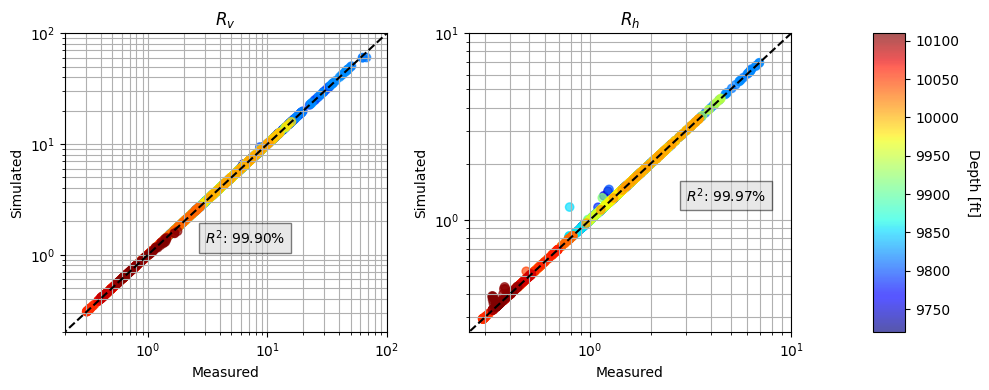

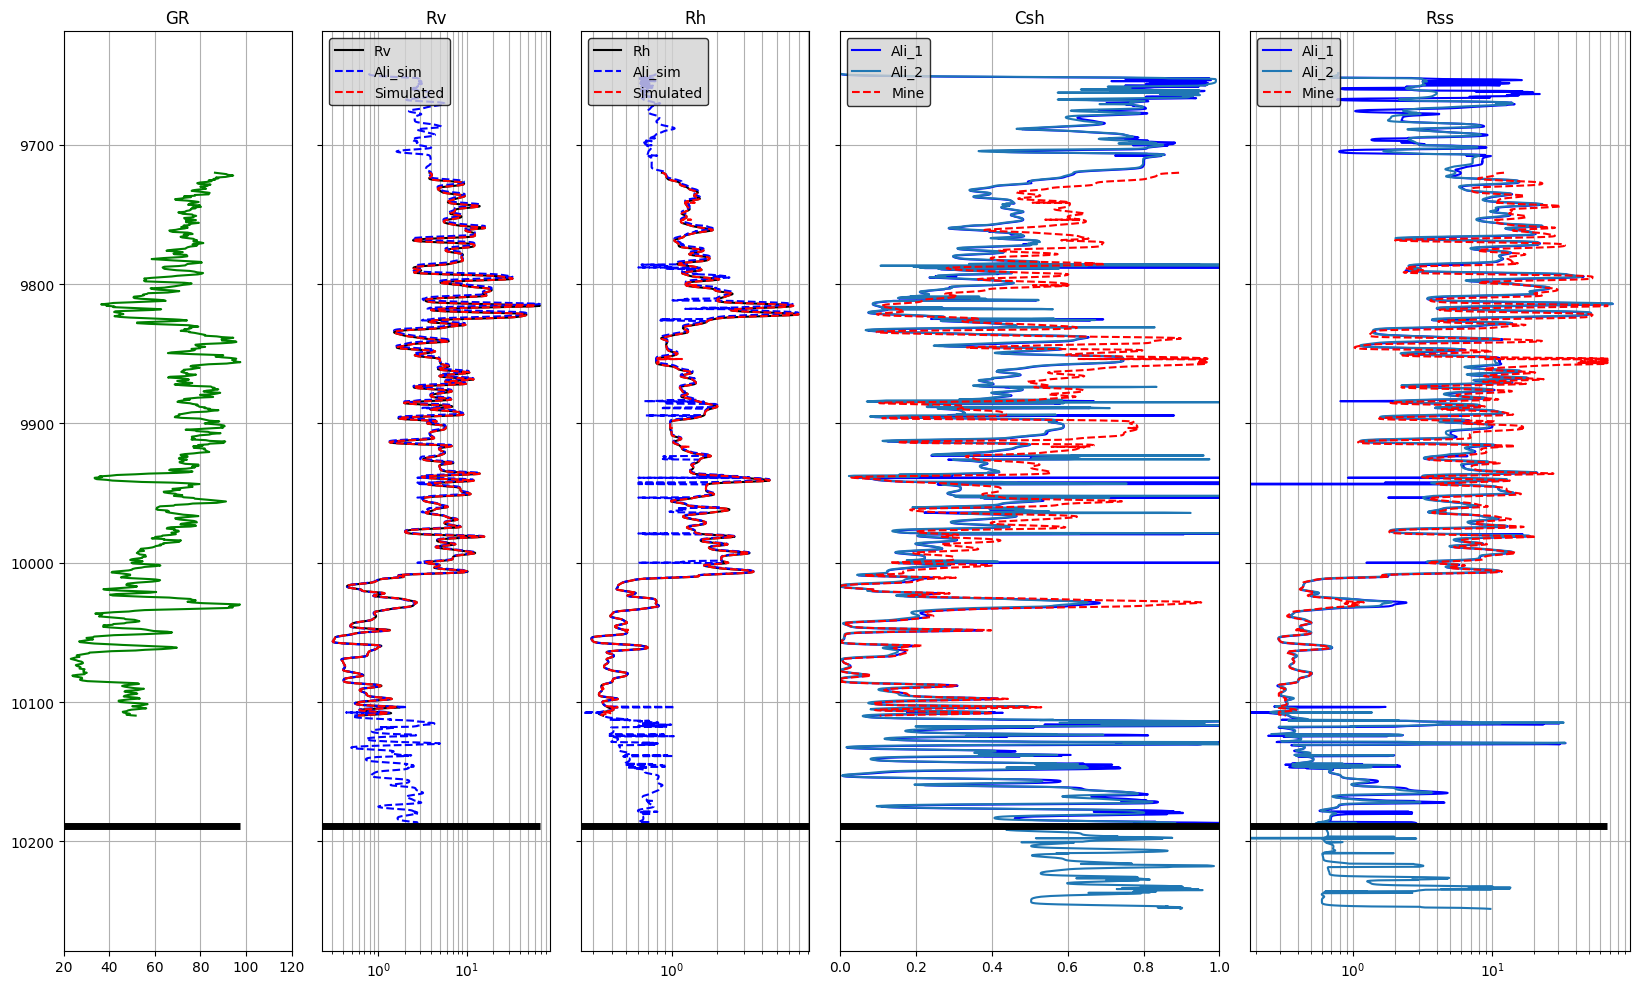

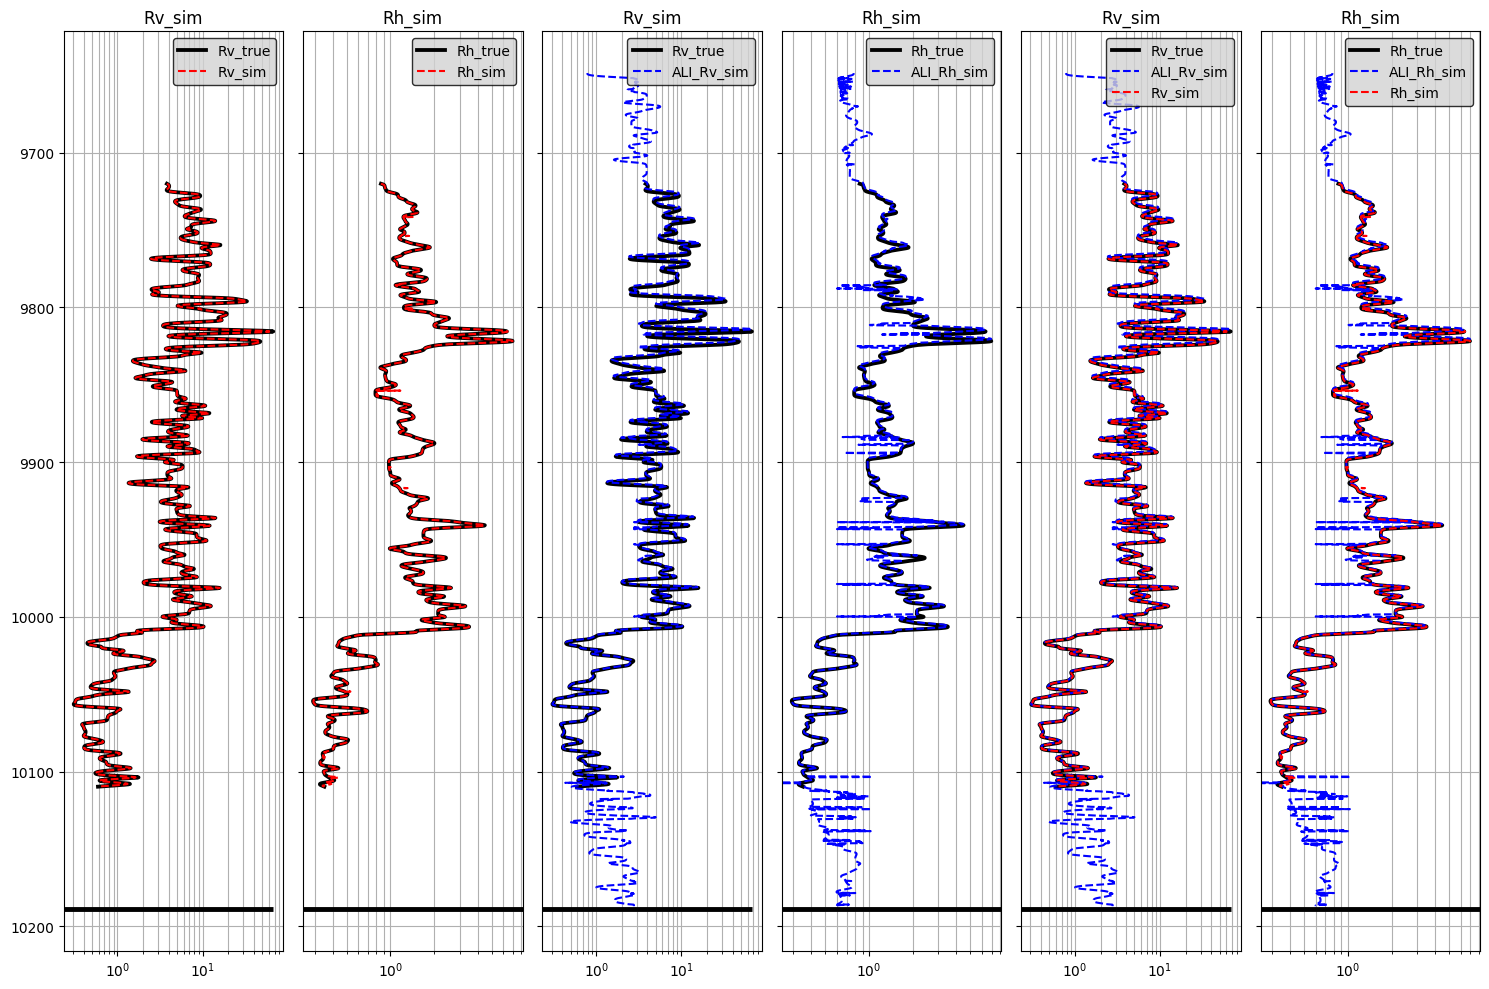

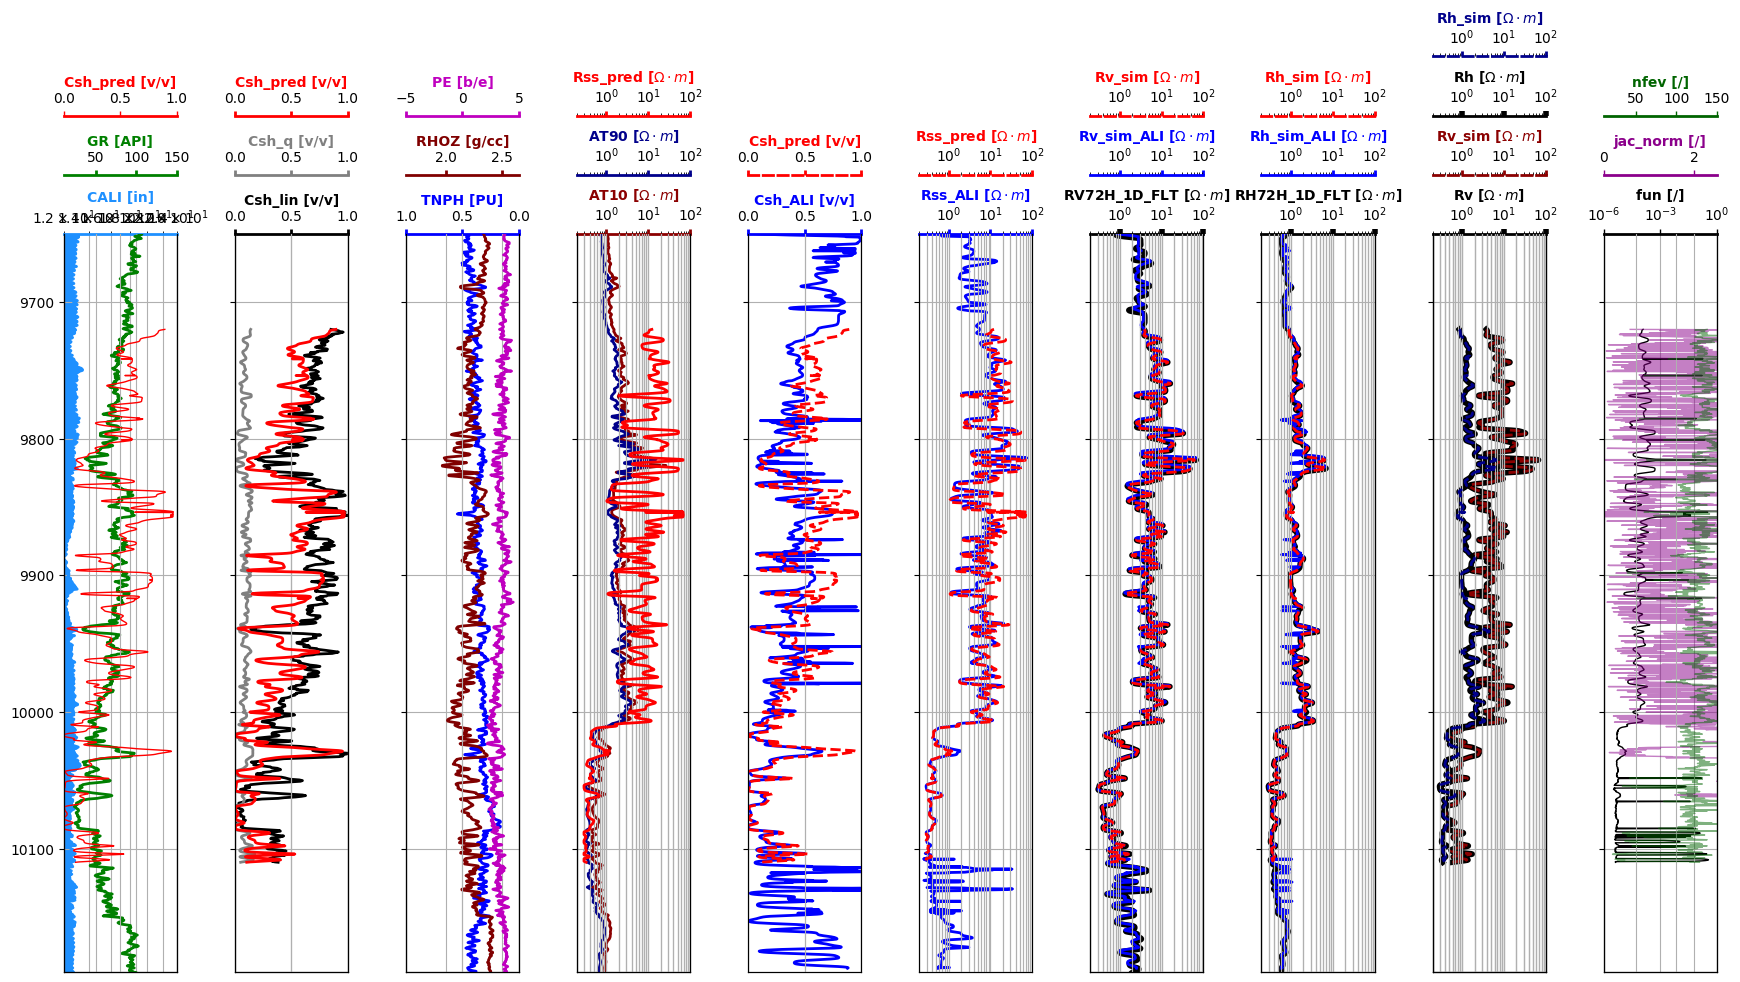

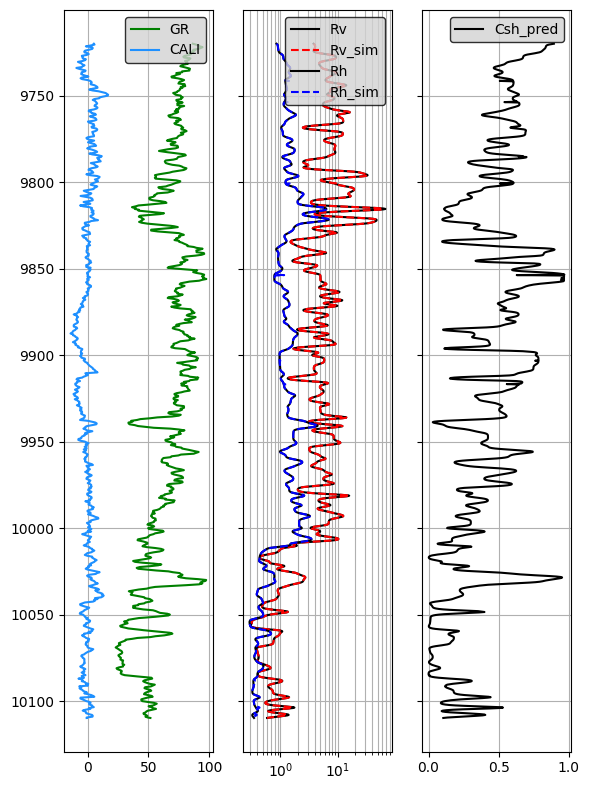

In [16]:
error_metrics(sol)

plot_crossplot(sol)
plot_inversion_solution(data, sol, ali_results)
plot_inversion_comparison(sol, ali_results)
plot_inversion_fullsuite(data, sol, ali_sol)
plot_short_results(data, sol)

***
### Synthetic Case 1

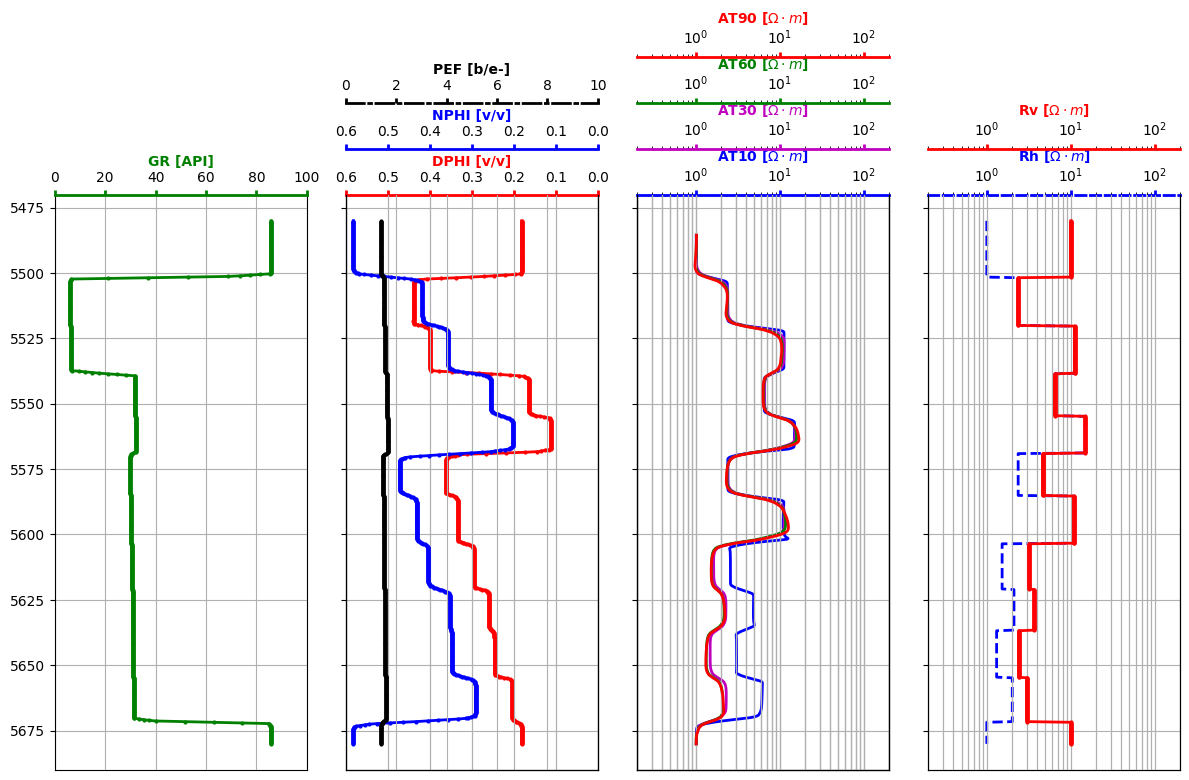

In [17]:
fig, axs = plt.subplots(1, 4, figsize=(12,8), sharey=True)
ax1, ax2, ax3, ax4 = axs

plot_curve(ax1, synthetic, 'GR', lb=0, ub=100, color='g', units='API', marker='o')

ax21, ax22 = ax2.twiny(), ax2.twiny()
plot_curve(ax2, synthetic, 'DPHI', lb=0.6, ub=0.0, color='r', units='v/v', marker='o')
plot_curve(ax21, synthetic, 'NPHI', lb=0.6, ub=0.0, color='b', units='v/v', marker='o', pad=8)
plot_curve(ax22, synthetic, 'PEF', lb=0, ub=10, color='k', ls='-.', units='b/e-', marker='o', pad=16)

ax31, ax32, ax33 = ax3.twiny(), ax3.twiny(), ax3.twiny()
plot_curve(ax3, synthetic, 'AT10', lb=0.2, ub=200, color='b', units='$\Omega\cdot m$', semilog=True)
plot_curve(ax31, synthetic, 'AT30', lb=0.2, ub=200, color='m', units='$\Omega\cdot m$', semilog=True, pad=8)
plot_curve(ax32, synthetic, 'AT60', lb=0.2, ub=200, color='g', units='$\Omega\cdot m$', semilog=True, pad=16)
plot_curve(ax33, synthetic, 'AT90', lb=0.2, ub=200, color='r', units='$\Omega\cdot m$', semilog=True, pad=24)

ax41 = ax4.twiny()
plot_curve(ax4, synthetic, 'Rh', lb=0.2, ub=200, color='b', ls='--', units='$\Omega\cdot m$', semilog=True)
plot_curve(ax41, synthetic, 'Rv', lb=0.2, ub=200, color='r', units='$\Omega\cdot m$', marker='o', semilog=True, pad=8)

[ax.grid(True, which='both') for ax in axs]
ax1.invert_yaxis()
plt.tight_layout()
plt.show()

In [18]:
synthetic['Csh_lin'] = (synthetic['GR'] - synthetic['GR'].min())/(synthetic['GR'].max() - synthetic['GR'].min())

sol = []
for i, row in synthetic.iterrows():
    Rv_value       = row['Rv']
    Rh_value       = row['Rh']
    Csh_lin_value  = row['Csh_lin']
    GR_value       = row['GR']
    Rvsh_value     = 10 #row['Rvsh_win'] #2.8133
    Rhsh_value     = 1 #row['Rhsh_win'] #0.7746

    x0 = (Csh_lin_value, np.mean([Rv_value, Rh_value]))
    c0 = (Rv_value, Rh_value, Rvsh_value, Rhsh_value, GR_value, CALI_value)
    res = optimize.minimize(objective,
                            x0          = x0,
                            args        = c0,
                            method      = 'L-BFGS-B',
                            #jac         = jacobian,
                            #hess        = hessian,
                            bounds      = bounds,
                            #constraints = constr,
                            tol         = 1e-6,
                            callback    = callback,
                            options     = {'maxiter':100},
                            )
    Csh_pred, Rss_pred = res.x
    sol.append({'Rv':Rv_value, 'Rh':Rh_value, 
                'Csh_pred':Csh_pred, 'Rss_pred':Rss_pred,
                'fun':res.fun, 'nfev':res.nfev, 'jac_norm':linalg.norm(res.jac),
                'Rv_sim':Csh_pred*Rvsh_value + (1-Csh_pred)*Rss_pred,
                'Rh_sim':1/(Csh_pred/Rhsh_value + (1-Csh_pred)/Rss_pred)})
    xall[i] = np.array([x0]+xhist)

sol = pd.DataFrame(sol, index=synthetic.index)
error_metrics(sol)

Mean Squared Error - Rv: 0.0027  | Rh: 0.0028
R2 Score           - Rv: 99.984  | Rh: 99.987
Standard Error     - Rv: 0.3168  | Rh: 0.3168
Percentage Error   - Rv: 0.1454% | Rh: 0.1431%


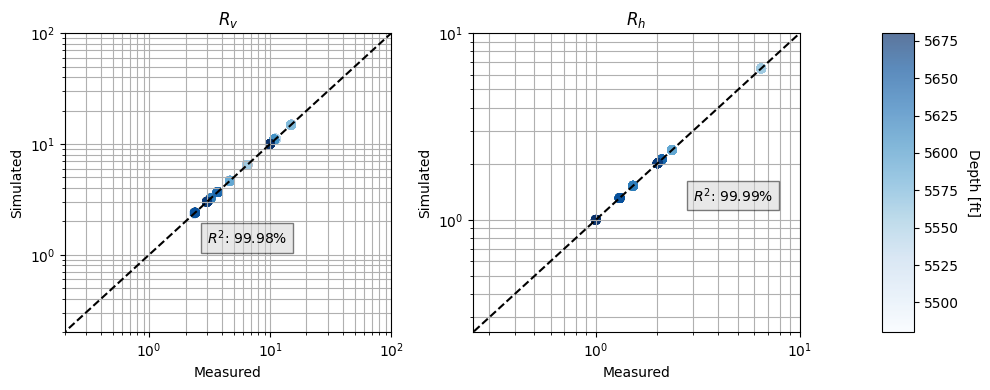

In [21]:
plot_crossplot(sol, cmap='Blues')

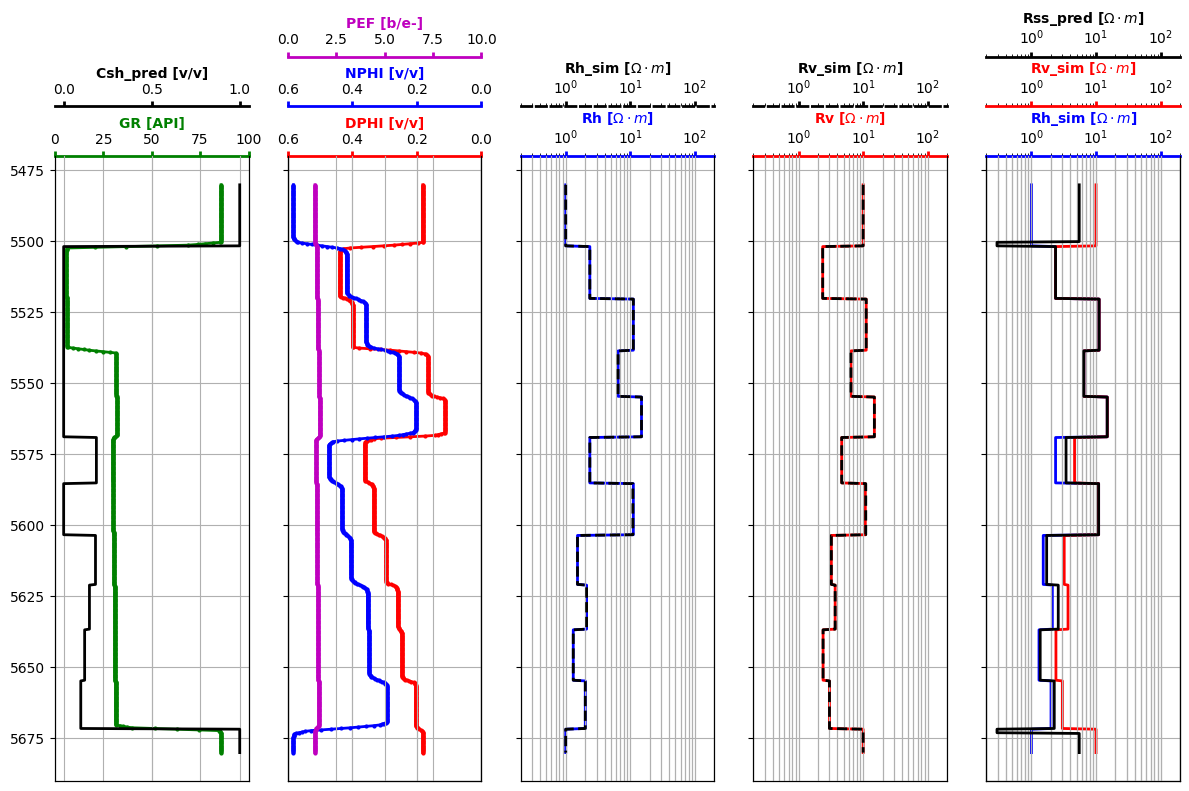

In [22]:
fig, axs = plt.subplots(1, 5, figsize=(12,8), sharey=True)
ax1, ax2, ax3, ax4, ax5 = axs

ax11 = ax1.twiny()
plot_curve(ax1, synthetic, 'GR', lb=0, ub=100, color='g', units='API', marker='o')
plot_curve(ax11, sol, 'Csh_pred', lb=-0.05, ub=1.05, color='k', units='v/v', pad=8)

ax21, ax22 = ax2.twiny(), ax2.twiny()
plot_curve(ax2, synthetic, 'DPHI', lb=0.6, ub=0.0, color='r', units='v/v', marker='o')
plot_curve(ax21, synthetic, 'NPHI', lb=0.6, ub=0.0, color='b', units='v/v', marker='o', pad=8)
plot_curve(ax22, synthetic, 'PEF', lb=0, ub=10, color='m', units='b/e-', marker='o', pad=16)

ax31 = ax3.twiny()
plot_curve(ax3, synthetic, 'Rh', lb=0.2, ub=200, color='b', units='$\Omega\cdot m$', semilog=True)
plot_curve(ax31, sol, 'Rh_sim', lb=0.2, ub=200, color='k', ls='--', units='$\Omega\cdot m$', semilog=True, pad=8)

ax41 = ax4.twiny()
plot_curve(ax4, synthetic, 'Rv', lb=0.2, ub=200, color='r', units='$\Omega\cdot m$', semilog=True)
plot_curve(ax41, sol, 'Rv_sim', lb=0.2, ub=200, color='k', ls='--', units='$\Omega\cdot m$', semilog=True, pad=8)

ax51, ax52 = ax5.twiny(), ax5.twiny()
plot_curve(ax5, sol, 'Rh_sim', lb=0.2, ub=200, color='b', units='$\Omega\cdot m$', semilog=True)
plot_curve(ax51, sol, 'Rv_sim', lb=0.2, ub=200, color='r', units='$\Omega\cdot m$', semilog=True, pad=8)
plot_curve(ax52, sol, 'Rss_pred', lb=0.2, ub=200, color='k', units='$\Omega\cdot m$', semilog=True, pad=16)

[ax.grid(True, which='both') for ax in axs]
ax1.invert_yaxis()
plt.tight_layout()
plt.show()

***
### Synthetic Case 2

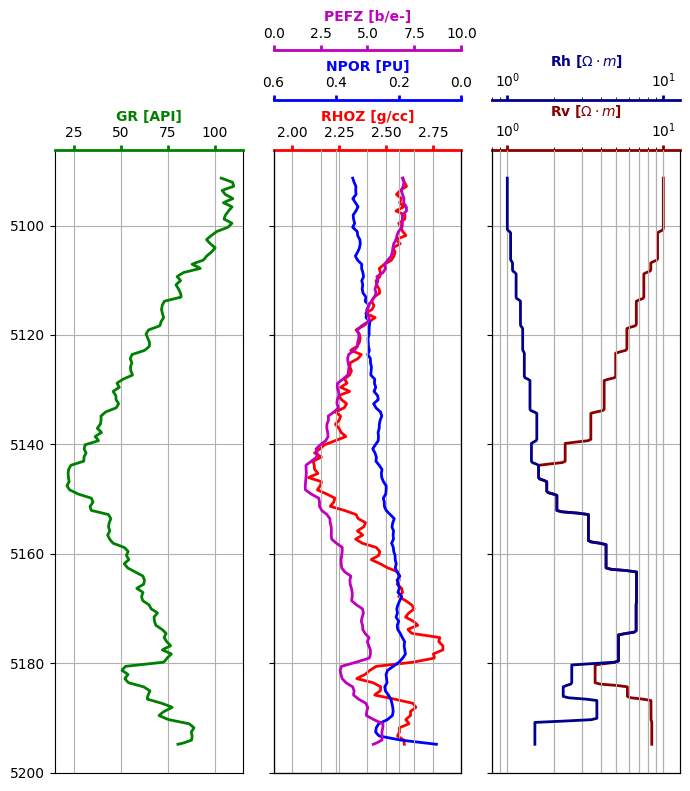

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(7,8), sharey=True)
ax1, ax2, ax3 = axs
ax21, ax22, ax31 = ax2.twiny(), ax2.twiny(), ax3.twiny()

plot_curve(ax1, synthetic2, 'GR', lb=15, ub=115, color='g', units='API')
plot_curve(ax2, synthetic2, 'RHOZ', lb=1.9, ub=2.9, color='r', units='g/cc')
plot_curve(ax21, synthetic2, 'NPOR', lb=0.6, ub=0.0, color='b', units='PU', pad=8)
plot_curve(ax22, synthetic2, 'PEFZ', lb=0, ub=10, color='m', units='b/e-', pad=16)
plot_curve(ax3, synthetic2, 'Rv', lb=0.8, ub=12.8, color='darkred', units='$\Omega\cdot m$', semilog=True)
plot_curve(ax31, synthetic2, 'Rh', lb=0.8, ub=12.8, color='darkblue', units='$\Omega\cdot m$', semilog=True, pad=8)

ax1.invert_yaxis()
[ax.grid(True, which='both') for ax in axs]
plt.tight_layout()
plt.show()

In [36]:
synthetic2['Csh_lin'] = (synthetic2['GR'] - synthetic2['GR'].min())/(synthetic2['GR'].max() - synthetic2['GR'].min())

sol = []
for i, row in synthetic2.iterrows():
    Rv_value       = row['Rv']
    Rh_value       = row['Rh']
    Csh_lin_value  = row['Csh_lin']
    GR_value       = row['GR']
    Rvsh_value     = 10 #row['Rvsh_win'] #2.8133
    Rhsh_value     = 1 #row['Rhsh_win'] #0.7746

    x0 = (Csh_lin_value, np.mean([Rv_value, Rh_value]))
    c0 = (Rv_value, Rh_value, Rvsh_value, Rhsh_value, GR_value, CALI_value)
    res = optimize.minimize(objective,
                            x0          = x0,
                            args        = c0,
                            method      = 'L-BFGS-B',
                            #jac         = jacobian,
                            #hess        = hessian,
                            bounds      = bounds,
                            #constraints = constr,
                            tol         = 1e-6,
                            callback    = callback,
                            options     = {'maxiter':100},
                            )
    Csh_pred, Rss_pred = res.x
    sol.append({'Rv':Rv_value, 'Rh':Rh_value, 
                'Csh_pred':Csh_pred, 'Rss_pred':Rss_pred,
                'fun':res.fun, 'nfev':res.nfev, 'jac_norm':linalg.norm(res.jac),
                'Rv_sim':Csh_pred*Rvsh_value + (1-Csh_pred)*Rss_pred,
                'Rh_sim':1/(Csh_pred/Rhsh_value + (1-Csh_pred)/Rss_pred)})
    xall[i] = np.array([x0]+xhist)

sol = pd.DataFrame(sol, index=synthetic2.index)
error_metrics(sol)

Mean Squared Error - Rv: 0.0000  | Rh: 0.0000
R2 Score           - Rv: 100.000  | Rh: 100.000
Standard Error     - Rv: 0.0499  | Rh: 0.0568
Percentage Error   - Rv: 0.0013% | Rh: 0.0008%


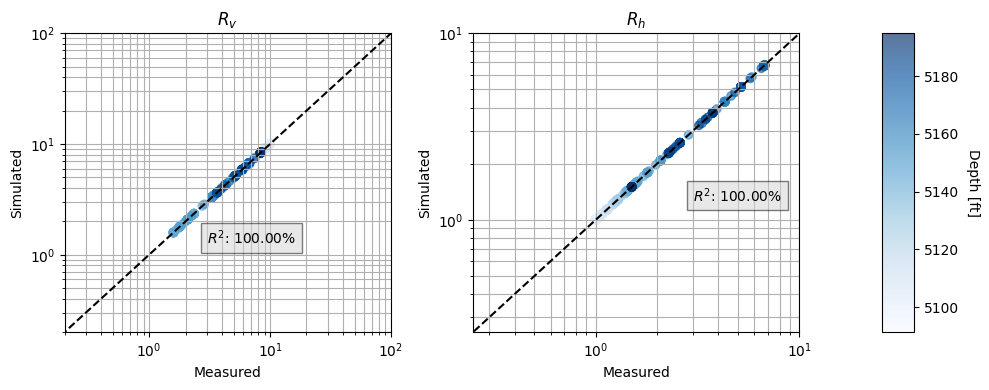

In [37]:
plot_crossplot(sol, cmap='Blues')

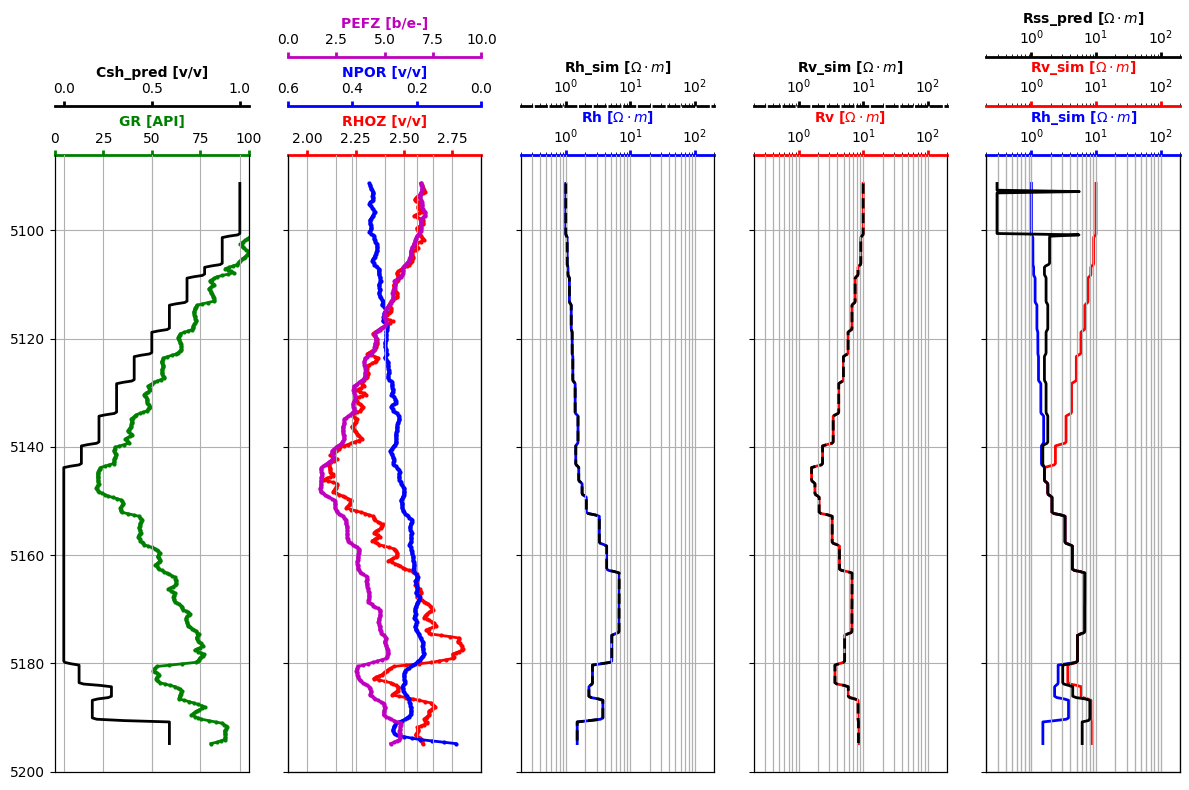

In [39]:
fig, axs = plt.subplots(1, 5, figsize=(12,8), sharey=True)
ax1, ax2, ax3, ax4, ax5 = axs

ax11 = ax1.twiny()
plot_curve(ax1, synthetic2, 'GR', lb=0, ub=100, color='g', units='API', marker='o')
plot_curve(ax11, sol, 'Csh_pred', lb=-0.05, ub=1.05, color='k', units='v/v', pad=8)

ax21, ax22 = ax2.twiny(), ax2.twiny()
plot_curve(ax2, synthetic2, 'RHOZ', lb=1.9, ub=2.9, color='r', units='v/v', marker='o')
plot_curve(ax21, synthetic2, 'NPOR', lb=0.6, ub=0.0, color='b', units='v/v', marker='o', pad=8)
plot_curve(ax22, synthetic2, 'PEFZ', lb=0, ub=10, color='m', units='b/e-', marker='o', pad=16)

ax31 = ax3.twiny()
plot_curve(ax3, synthetic2, 'Rh', lb=0.2, ub=200, color='b', units='$\Omega\cdot m$', semilog=True)
plot_curve(ax31, sol, 'Rh_sim', lb=0.2, ub=200, color='k', ls='--', units='$\Omega\cdot m$', semilog=True, pad=8)

ax41 = ax4.twiny()
plot_curve(ax4, synthetic2, 'Rv', lb=0.2, ub=200, color='r', units='$\Omega\cdot m$', semilog=True)
plot_curve(ax41, sol, 'Rv_sim', lb=0.2, ub=200, color='k', ls='--', units='$\Omega\cdot m$', semilog=True, pad=8)

ax51, ax52 = ax5.twiny(), ax5.twiny()
plot_curve(ax5, sol, 'Rh_sim', lb=0.2, ub=200, color='b', units='$\Omega\cdot m$', semilog=True)
plot_curve(ax51, sol, 'Rv_sim', lb=0.2, ub=200, color='r', units='$\Omega\cdot m$', semilog=True, pad=8)
plot_curve(ax52, sol, 'Rss_pred', lb=0.2, ub=200, color='k', units='$\Omega\cdot m$', semilog=True, pad=16)

[ax.grid(True, which='both') for ax in axs]
ax1.invert_yaxis()
plt.tight_layout()
plt.show()

***
### Uncertainty Quantification

In [23]:
d = lasio.read('well1.las').df()[['CALI', 'AT10','AT30','AT60','AT90','GR','RV72H_1D_FLT','RH72H_1D_FLT']].dropna()
column_names = ['CALI', 'AT10', 'AT30', 'AT60', 'AT90', 'GR', 'Rv', 'Rh']

zstart = int(np.argwhere(d.index==9720).squeeze())
zend   = int(np.argwhere(d.index==10110).squeeze())
data = d.rename(columns=dict(zip(d.columns, column_names))).iloc[zstart:zend]

data['Csh_lin']  = (data['GR'] - data['GR'].min())/(data['GR'].max() - data['GR'].min())
qinv = np.abs(quadratic_inversion(data))
data = data.join(qinv)

data['Rvsh_win'] = 2.78
data['Rhsh_win'] = 0.58
data

,CALI,AT10,AT30,AT60,AT90,GR,Rv,Rh,Csh_lin,Rss_q,Csh_q,Rvsh_win,Rhsh_win
DEPTH:1,,,,,,,,,,,,,
9720.00,12.8824,1.5269,1.1963,1.1103,1.1101,86.3898,3.8097,0.8607,0.850451,4.559357,0.140053,2.78,0.58
9720.25,12.8969,1.5301,1.2093,1.1268,1.1215,87.6158,3.8877,0.8783,0.866923,4.621137,0.138185,2.78,0.58
9720.50,12.9115,1.5334,1.2223,1.1433,1.1328,88.8418,3.9521,0.8921,0.883394,4.677001,0.136683,2.78,0.58
9720.75,12.8370,1.5219,1.2123,1.1382,1.1203,90.0982,3.9985,0.9017,0.900274,4.719534,0.135620,2.78,0.58
9721.00,12.7624,1.5104,1.2023,1.1331,1.1078,91.3546,4.0274,0.9076,0.917154,4.746600,0.134965,2.78,0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10108.75,12.8334,0.5257,0.3909,0.3650,0.3712,48.3005,1.0388,0.3308,0.338714,3.097628,0.128769,2.78,0.58
10109.00,12.8279,0.5338,0.3938,0.3680,0.3706,47.5221,0.8795,0.3351,0.328256,2.858790,0.105909,2.78,0.58
10109.25,12.7061,0.5327,0.3938,0.3691,0.3695,48.4963,0.7495,0.3403,0.341344,2.683110,0.083523,2.78,0.58


In [24]:
grmax, calimax = data['GR'].max(), data['CALI'].max()
lambda_reg = 1e-5
n_realizations = 25

all_sol = []
for n in range(n_realizations):
    sol = []
    data['Rv'] = data['Rv'] + 0.1*data['Rv']*np.random.randn(len(data['Rv']))
    data['Rh'] = data['Rh'] + 0.1*data['Rh']*np.random.randn(len(data['Rh']))

    sol = []
    for i, row in data.iterrows():
        Rv_value       = row['Rv'] 
        Rh_value       = row['Rh']
        Csh_lin_value  = row['Csh_lin']
        GR_value       = row['GR']
        CALI_value     = row['CALI']
        Rvsh_value     = 2.813 #row['Rvsh_win'] #2.8133
        Rhsh_value     = 0.775 #row['Rhsh_win'] #0.7746

        x0 = (Csh_lin_value, np.mean([Rv_value, Rh_value]))
        c0 = (Rv_value, Rh_value, Rvsh_value, Rhsh_value, GR_value, CALI_value)
        res = optimize.minimize(objective,
                                x0          = x0,
                                args        = c0,
                                method      = 'L-BFGS-B',
                                #jac         = jacobian,
                                #hess        = hessian,
                                bounds      = bounds,
                                #constraints = constr,
                                tol         = 1e-6,
                                callback    = None, #callback
                                options     = {'maxiter':100},
                                )
        Csh_pred, Rss_pred = res.x
        sol.append({'Rv':Rv_value, 'Rh':Rh_value, 
                    'Csh_pred':Csh_pred, 'Rss_pred':Rss_pred,
                    'fun':res.fun, 'nfev':res.nfev, 'jac_norm':linalg.norm(res.jac),
                    'Rv_sim':Csh_pred*Rvsh_value + (1-Csh_pred)*Rss_pred,
                    'Rh_sim':1/(Csh_pred/Rhsh_value + (1-Csh_pred)/Rss_pred)})

    sol = pd.DataFrame(sol, index=data.index)

    all_sol.append(sol)

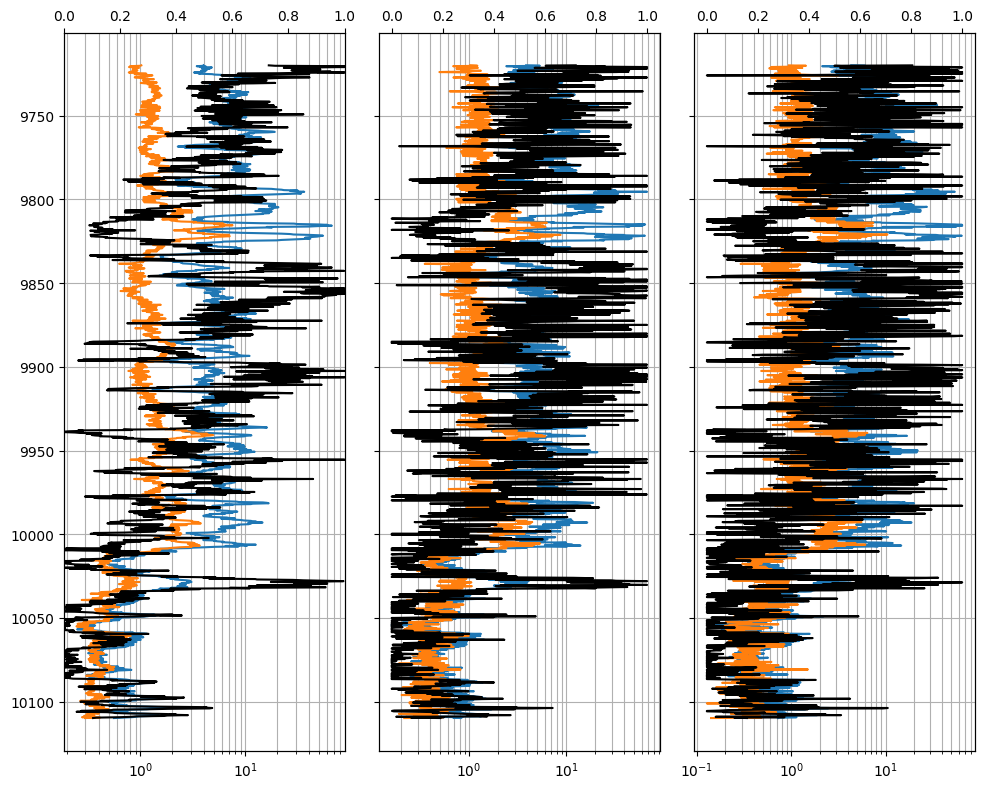

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(10,8), sharey=True)
ax1, ax2, ax3 = axs

ax11 = ax1.twiny()
ax1.plot(all_sol[0]['Rv'], all_sol[0].index)
ax1.plot(all_sol[0]['Rh'], all_sol[0].index)
ax11.plot(all_sol[0]['Csh_pred'], all_sol[0].index, c='k'); ax11.set(xlim=(0,1))

ax12 = ax2.twiny()
ax2.plot(all_sol[5]['Rv'], all_sol[5].index)
ax2.plot(all_sol[5]['Rh'], all_sol[5].index)
ax12.plot(all_sol[5]['Csh_pred'], all_sol[5].index, c='k'); ax11.set(xlim=(0,1))

ax13 = ax3.twiny()
ax3.plot(all_sol[9]['Rv'], all_sol[9].index)
ax3.plot(all_sol[9]['Rh'], all_sol[9].index)
ax13.plot(all_sol[9]['Csh_pred'], all_sol[9].index, c='k'); ax11.set(xlim=(0,1))

[ax.grid(True, which='both') for ax in axs]
[ax.set(xscale='log') for ax in axs]
ax1.invert_yaxis()
plt.tight_layout()
plt.show()

In [29]:
all_csh = np.array([sol['Csh_pred'] for sol in all_sol])
all_rss = np.array([sol['Rss_pred'] for sol in all_sol])
all_rv  = np.array([sol['Rv_sim'] for sol in all_sol])
all_rh  = np.array([sol['Rh_sim'] for sol in all_sol])

all_ensemble = [all_csh, all_rss, all_rv, all_rh]
all_titles   = ['Csh_pred', 'Rss_pred', 'Rv_sim', 'Rh_sim']

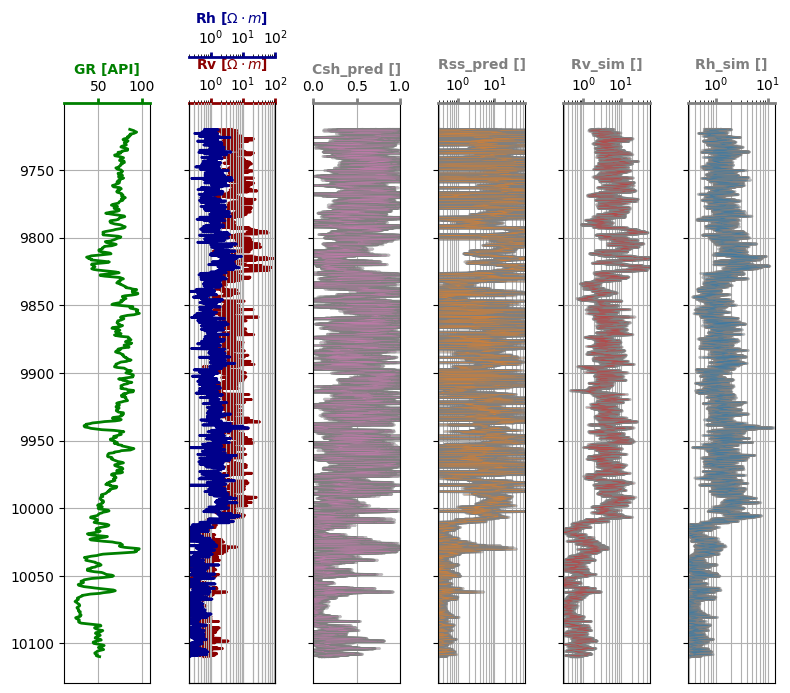

In [30]:
fig, axs = plt.subplots(1, 6, figsize=(8,7), sharey=True)
ax1, ax2, ax3, ax4, ax5, ax6 = axs
colors = ['tab:pink', 'tab:orange', 'tab:red', 'tab:blue']

tstep = 50

ax21 = ax2.twiny()
plot_curve(ax1, data, 'GR', 10, 110, color='g', units='API')
plot_curve(ax2, data, 'Rv', 0.2, 100, color='darkred', units='$\Omega\cdot m$', semilog=True)
plot_curve(ax21, data, 'Rh', 0.2, 100, color='darkblue', units='$\Omega\cdot m$', semilog=True, pad=8)


for i in range(n_realizations):
    for k in range(len(all_ensemble)):
        plot_curve(axs[k+2], all_sol[i], all_titles[k], color='gray', alpha=0.5)
        axs[k+2].plot(all_ensemble[k][i], all_sol[i].index, color=colors[k], lw=0.1)

[ax.grid(True, which='both') for ax in axs]
[ax.set(xscale='log') for ax in axs[[1,3,4,5]]]
axs[0].invert_yaxis()
plt.tight_layout()
plt.show()

***
# END